In [19]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

import time
import matplotlib.pyplot as plt
import numpy as np


In [2]:
dataset = datasets.ImageFolder(
    'dataset',
    transforms.Compose([
        transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

In [3]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - 65, 65])

In [4]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
)

In [5]:
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, 2)

In [6]:
device = torch.device('cuda')
model = model.to(device)

In [7]:
import datetime
today = datetime.date.today()
strToday = str(today.year) + '_' + str(today.month) + '_' + str(today.day)

RESNET_MODEL = 'Botline_CA_model_resnet18_' + strToday + '.pth'
TRT_MODEL = 'Botline_CA_model_resnet18_trt_' + strToday + '.pth'

In [51]:
NUM_EPOCHS = 50                                                                     
best_accuracy = 0.0

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

accuracyList = list()
timeList = list()

startTime = time.time()
for epoch in range(NUM_EPOCHS):
    t0 = time.time()
    for images, labels in iter(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
    
    test_error_count = 0.0
    for images, labels in iter(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_error_count += float(torch.sum(torch.abs(labels - outputs.argmax(1))))
    elapsedTime = time.time() - t0

    test_accuracy = 1.0 - float(test_error_count) / float(len(test_dataset))
    accuracyList.append(test_accuracy)
    timeList.append(elapsedTime)

    print('[%2d] Accuracy: %f\tTime : %.2f sec' % (epoch, test_accuracy, elapsedTime))
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), RESNET_MODEL)
        best_accuracy = test_accuracy
endTime = time.time()

[ 0] Accuracy: 0.984615	Time : 1.88 sec
[ 1] Accuracy: 0.969231	Time : 1.85 sec
[ 2] Accuracy: 0.938462	Time : 1.77 sec
[ 3] Accuracy: 0.953846	Time : 1.85 sec
[ 4] Accuracy: 0.969231	Time : 1.85 sec
[ 5] Accuracy: 0.846154	Time : 1.90 sec
[ 6] Accuracy: 1.000000	Time : 2.01 sec
[ 7] Accuracy: 0.984615	Time : 1.96 sec
[ 8] Accuracy: 0.969231	Time : 1.93 sec
[ 9] Accuracy: 0.969231	Time : 1.84 sec
[10] Accuracy: 0.969231	Time : 1.88 sec
[11] Accuracy: 0.953846	Time : 1.82 sec
[12] Accuracy: 0.984615	Time : 1.84 sec
[13] Accuracy: 0.984615	Time : 1.86 sec
[14] Accuracy: 0.984615	Time : 1.86 sec
[15] Accuracy: 1.000000	Time : 1.83 sec
[16] Accuracy: 0.969231	Time : 1.87 sec
[17] Accuracy: 0.892308	Time : 1.86 sec
[18] Accuracy: 0.969231	Time : 1.88 sec
[19] Accuracy: 0.969231	Time : 1.81 sec
[20] Accuracy: 0.953846	Time : 1.83 sec
[21] Accuracy: 0.969231	Time : 1.84 sec
[22] Accuracy: 0.984615	Time : 1.83 sec
[23] Accuracy: 1.000000	Time : 1.91 sec
[24] Accuracy: 0.984615	Time : 1.90 sec


Time: 178.63


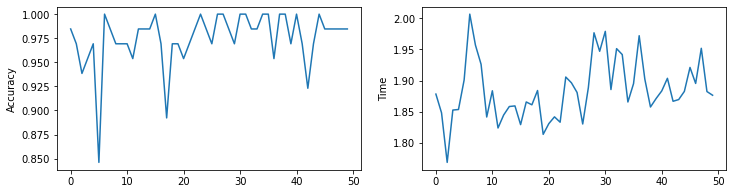

In [78]:
print('Time: {0:.2f}'.format(endTime - startTime))

plt.figure(figsize=(12, 3))
accX = range(len(accuracyList))
plt.subplot(121)
plt.plot(accX, accuracyList)
plt.ylabel('Accuracy')

timeX = range(len(timeList))
plt.subplot(122)
plt.plot(timeX, timeList)
plt.ylabel('Time')
plt.show()